In [15]:
import numpy as np
import cv2
import glob
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import matplotlib.image as mpimg

%matplotlib inline

# Calibrating the camera

### 1. Get points from calibration images

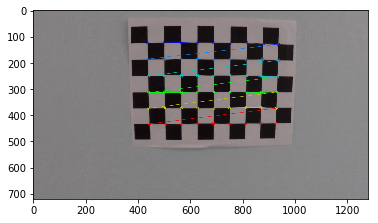

In [2]:
num_corners = [6,9]    # Number of inner corners in calibration images

objp = np.zeros((num_corners[0]*num_corners[1],3), np.float32)
objp[:,:2] = np.mgrid[0:num_corners[1], 0:num_corners[0]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (num_corners[1],num_corners[0]), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (num_corners[1],num_corners[0]), corners, ret)
        clear_output()
        plt.imshow(img)
        plt.show()
        time.sleep(1)

### 2. Calculate and save distortion coefficients

In [4]:
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use.
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/coefficients.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

### 3. Load calibration coefficients

In [10]:
coeff = pickle.load( open( "camera_cal/coefficients.p", "rb" ) )
mtx = coeff['mtx']
dist = coeff['dist']

### 3. Test undistortion on an image

In [13]:
def undistort(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

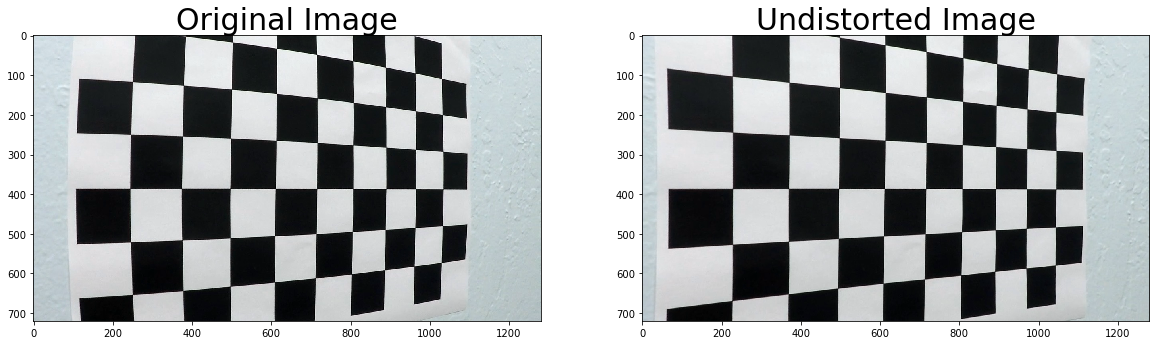

In [14]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')

dst = undistort(img,mtx,dist)
cv2.imwrite('examples/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Transform Perspective

In [61]:
def get_eagle_eye(img, src, offset):
    img_size = (img.shape[1],img.shape[0])

    # Define 4 destination points
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                 [img_size[0]-offset, img_size[1]], 
                                 [offset, img_size[1]]])
    # Get the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, dst

In [62]:
def draw_points(img, points):
    img = cv2.line(img, tuple(points[0]), tuple(points[1]), color=(0,0,255), thickness=4)
    img = cv2.line(img, tuple(points[1]), tuple(points[2]), color=(0,0,255), thickness=4)
    img = cv2.line(img, tuple(points[2]), tuple(points[3]), color=(0,0,255), thickness=4)
    img = cv2.line(img, tuple(points[3]), tuple(points[0]), color=(0,0,255), thickness=4)
    return img

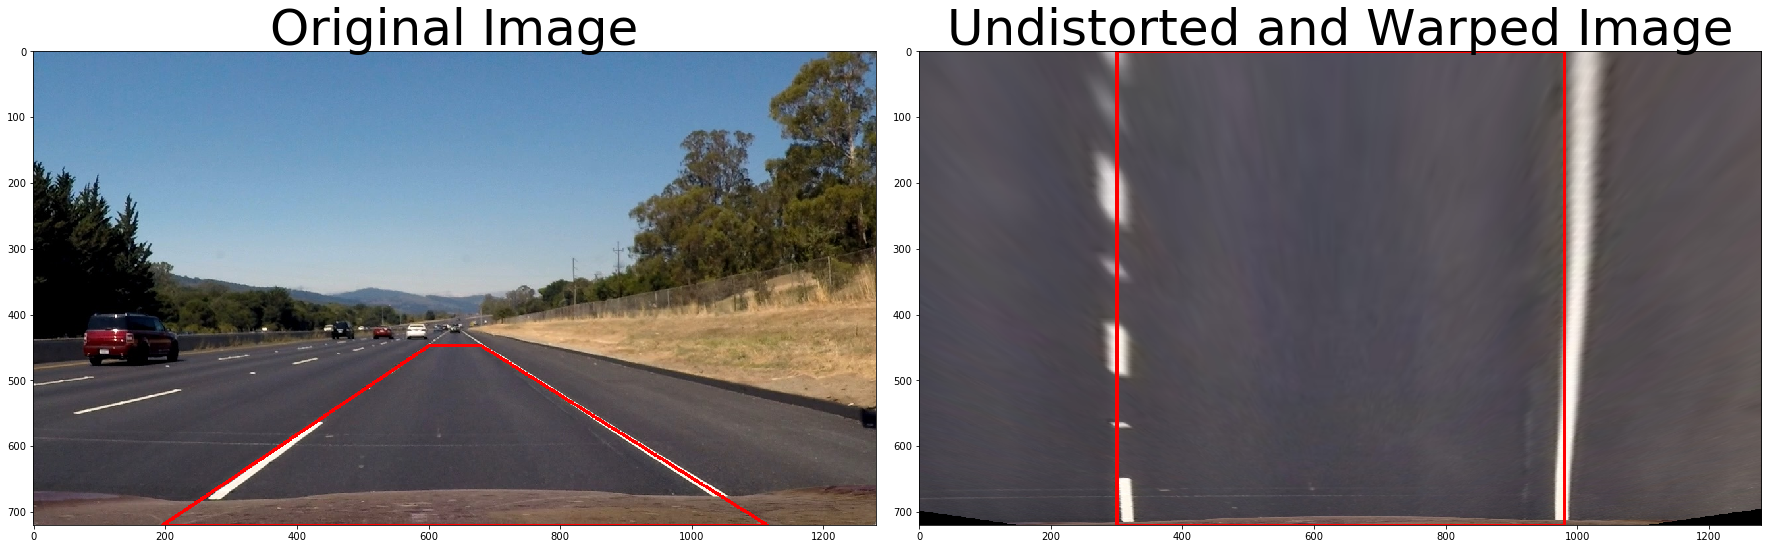

In [77]:
# Read in an image
#img = mpimg.imread('test_images/straight_lines1.jpg')
original = cv2.imread('test_images/straight_lines2.jpg')
img = undistort(original,mtx,dist)

src_points = np.float32([[601,447],[680,447],[1115,720],[196,720]])

top_down, dst_points = get_eagle_eye(img, src_points, 300.0)

original = draw_points(original,src_points)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

top_down = draw_points(top_down,dst_points)
top_down = cv2.cvtColor(top_down, cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)